# LeafSnap data 30-subset preparation

The original dataset has been downloaded from [kaggle.com](https://www.kaggle.com/xhlulu/leafsnap-dataset) as [leafsnap.com](leafsnap.com/dataset) is not available any more. It is stored at [SURF drive](https://surfdrive.surf.nl/files/index.php/s/MoCVal7gxS4aX51?path=%2Fdata%2FLeafSnap). There are 30 866 (~31k) color images of different sizes. The dataset covers all 185 tree species from the Northeastern United States. The original images of leaves taken from two different sources:

    "Lab" images, consisting of high-quality images taken of pressed leaves, from the Smithsonian collection.
    "Field" images, consisting of "typical" images taken by mobile devices (iPhones mostly) in outdoor environments.

For the purpose of this demo a subset of 30 species of lab and field images has been selected. The lab images have been cropped semi-manually using IrfanView to remove the riles and color calibration image parts. This results in a  dataset of 6136 images.

This notebook (based on a [student project notebook]) is used to load the cropped images resize to images to 64x64, normalize the data and save the files as numpy compressed (NPZ). 

### Imports

In [1]:
import warnings
warnings.simplefilter('ignore')
import os
import PIL
import imageio
import pandas as pd
import numpy as np
import random
import math
import keras

Using TensorFlow backend.



### Read data frame with information about pictures

In the dataset, there is a data frame containing information about the pictures. Relevant for us are the columns:

    path: path to the individual pictures
    species: latin term for each plant
    source: picture taken in lab or field



In [10]:
# data paths
original_data_path = "/home/elena/eStep/XAI/Data/LeafSnap/leafsnap-dataset-30subset/"
#images_folder = os.join(original_data_patn, "dataset")
dataset_info_file = os.path.join(original_data_path, "leafsnap-dataset-30subset-images.txt")

img_info = pd.read_csv(dataset_info_file, sep="\t")
img_info.head()

,file_id,image_path,species,source
0,55821,dataset/images/lab/Auto_cropped/acer_campestre...,Acer campestre,lab
1,55822,dataset/images/lab/Auto_cropped/acer_campestre...,Acer campestre,lab
2,55823,dataset/images/lab/Auto_cropped/acer_campestre...,Acer campestre,lab
3,55824,dataset/images/lab/Auto_cropped/acer_campestre...,Acer campestre,lab
4,55825,dataset/images/lab/Auto_cropped/acer_campestre...,Acer campestre,lab


Add new column for the filename only.

In [11]:
#new column (empty)
img_info["filename"] = None
#index of new column
index_filename = img_info.columns.get_loc("filename")
for i in range(len(img_info)):
    img_info.iloc[i, index_filename] = os.path.basename(str(img_info["image_path"][i]))
img_info.head()    

,file_id,image_path,species,source,filename
0,55821,dataset/images/lab/Auto_cropped/acer_campestre...,Acer campestre,lab,ny1079-01-1.jpg
1,55822,dataset/images/lab/Auto_cropped/acer_campestre...,Acer campestre,lab,ny1079-01-2.jpg
2,55823,dataset/images/lab/Auto_cropped/acer_campestre...,Acer campestre,lab,ny1079-01-3.jpg
3,55824,dataset/images/lab/Auto_cropped/acer_campestre...,Acer campestre,lab,ny1079-01-4.jpg
4,55825,dataset/images/lab/Auto_cropped/acer_campestre...,Acer campestre,lab,ny1079-02-1.jpg


### Create numeric labels

Then, we want to have numeric labels instead of the latin term for each plant, so we append another column holding these.

    In the data frame, all images of one species are listed consecutively (first the lab images, then the field images).
    Therefore we just loop over the dataframe and increment the numeric label whenever we encounter a latin term that differs from the previous one.



In [12]:
#new column (empty)
img_info["labels_integer"] = None
#index of new column
index_labels_integer = img_info.columns.get_loc("labels_integer")
#index of species column
index_species = img_info.columns.get_loc("species")
#to assign numeric labels starting with 0 for the first species
k = 0 
for i in range(len(img_info)):
    if i == 0:
        img_info.iloc[i, index_labels_integer] = k #here, k == 0
    if i > 0:
        if img_info.iloc[i-1, index_species] == img_info.iloc[i, index_species]:
            img_info.iloc[i, index_labels_integer] = k
        else:
            k += 1
            img_info.iloc[i, index_labels_integer] = k
img_info.tail()


,file_id,image_path,species,source,filename,labels_integer
6131,1736031,dataset/images/field/quercus_montana/132922311...,Quercus montana,field,13292231173082.jpg,29
6132,1736033,dataset/images/field/quercus_montana/132922311...,Quercus montana,field,13292231179955.jpg,29
6133,1736034,dataset/images/field/quercus_montana/132922311...,Quercus montana,field,13292231170979.jpg,29
6134,1736035,dataset/images/field/quercus_montana/132922311...,Quercus montana,field,13292231172496.jpg,29
6135,1736036,dataset/images/field/quercus_montana/132922311...,Quercus montana,field,13292231170554.jpg,29


Save dataframe.

In [13]:
dataset_info_file_enh = os.path.join(original_data_path, "leafsnap-dataset-30subset-images-enhanced.txt")
img_info.to_csv(dataset_info_file_enh, index=False)

### Resize pictures

Resizing the pictures to 64x64 is done by reading the filenames from the data frame, generating a resizedversion of the desired size for each picture and saving them to an output directory.


In [14]:
def resizeImage(infile, infile_name_only, output_dir="", size=(64,64)):
    '''
    Resize Images to a requested size (not considerinng aspect ratio)
    Input:
      - infile: image to be resized (with path)
      - infile_name_only: image to be resized (filename only)
      - output_dir: where resized images should be stored
      - size: output size (tuple of (height, width))
    '''
    infullfname = os.path.join(original_data_path, infile)
    outfullfname = os.path.join(output_dir, infile_name_only)
    #print(outfullfname)
      #if infile != outfullfname:
    if not os.path.isfile(outfullfname):
        try:
            im = PIL.Image.open(infullfname)
            #crops to requested size independant from aspect ratio
            im = im.resize(size, PIL.Image.ANTIALIAS) 
            im.save(outfullfname)
        except IOError:
            print("cannot reduce image for ", infullfname)

output_dir = os.path.join(original_data_path,"dataset","resized")
size = (64, 64)
filenames_dir = list(img_info["image_path"])
filenames = list(img_info["filename"])
            
for i in range(len(filenames)):
    resizeImage(filenames_dir[i], filenames[i], output_dir=output_dir, size=size)

### Read pictures as RGB arrays

RGB arrays: All resized images are read as rgb arrays in the order they are listed in the data frame. An RGB array is a numeric representation of a picture, assigning three color values (one for each of the three channels: red, green and blue) to each pixel. From a 64x64 picture, we therefore get a 64x64x3 rgb array.


In [15]:
# Load the saved info file
original_data_path = "/home/elena/eStep/XAI/Data/LeafSnap/leafsnap-dataset-30subset/"
dataset_info_file_enh = os.path.join(original_data_path, "leafsnap-dataset-30subset-images-enhanced.txt")
img_info = pd.read_csv(dataset_info_file_enh)
img_info.tail()

,file_id,image_path,species,source,filename,labels_integer
6131,1736031,dataset/images/field/quercus_montana/132922311...,Quercus montana,field,13292231173082.jpg,29
6132,1736033,dataset/images/field/quercus_montana/132922311...,Quercus montana,field,13292231179955.jpg,29
6133,1736034,dataset/images/field/quercus_montana/132922311...,Quercus montana,field,13292231170979.jpg,29
6134,1736035,dataset/images/field/quercus_montana/132922311...,Quercus montana,field,13292231172496.jpg,29
6135,1736036,dataset/images/field/quercus_montana/132922311...,Quercus montana,field,13292231170554.jpg,29


In [16]:
resized_dir = os.path.join(original_data_path,"dataset","resized")
index_filename = img_info.columns.get_loc("filename")
list_vectors = []

for i in range(len(img_info)):
    #path to resized images
    file = os.path.join(resized_dir, img_info.iloc[i, index_filename])
    #read as rgb array
    img = imageio.imread(file)
    #append image vector to list
    list_vectors.append(img)


### Randomize picture order

As a next step, we want to randomize the order in which the picture data is fed to the CNN to prevent sequence effects, as the data frame comes ordered by species (We don't shuffle the dataframe with df.sample, as we don't want to add the really big list_vectors to the data frame).


In [17]:
#relevant variables
label = img_info["species"]
source = img_info["source"]
label_numeric = img_info["labels_integer"]
list_vectors = list_vectors
filename = img_info["filename"]
path = img_info["image_path"]

#randomization
allinfo = list(zip(label, source, label_numeric, list_vectors, filename, path)) 
random.shuffle(allinfo) #shuffle
label, source, label_numeric, list_vectors, filename, path = zip(*allinfo) #decompose again
img_info_rand = pd.DataFrame({"filename":filename, "label":label, "source":source, "label_numeric":label_numeric, "path":path}) #store picture information in randomized order

### Stack picture input into one array

Now, the picture vectors should be stacked vertically into one array, so that each row represents one picture. This array's shape should then be (30866, 64, 64, 3), as we have 30866 pictures, represented in a 64x64x3 array each.


In [18]:
images = np.stack((list_vectors))

#transform numeric labels into array
labels = np.asarray(label_numeric)

print(images.shape)
print(labels.shape)

(6136, 64, 64, 3)
(6136,)


### Normalize input features (pictures) and one-hot encode labels

Finally, we normalize the picture data (dividing by 255, as there are 255 conditions possible for each rgb channel) and one-hot encode the numeric labels. One-hot encoding means to go from a representation where each numeric label is just one number (eg 14 for the 14th of 185 classes, so that we have a vector with 30866 entries for our 30866 pictures), to a representation where in a array each column represents a class and each row a picture. Here, picture number n being of class 14 is represented in the nth row, and only the 14th column contains a one, while all others hold zeros.


In [19]:
images = images/255
labels_one_hot = keras.utils.to_categorical(labels,30)
print(labels_one_hot.shape)

(6136, 30)


###  Save input features, labels and further info

We can save the input features, labels, and the further information about the pictures (in the randomized order) so that we don't have to repeat all the above steps in the next session.


In [20]:
images_fname = os.path.join(original_data_path, "images.npz")
labels_fname = os.path.join(original_data_path, "labels.npz")
info_fname_rand = os.path.join(original_data_path, "leafsnap-dataset-30subset-images-enhanced-randomized.txt")
np.savez(images_fname, images=images)
np.savez(labels_fname, labels_one_hot=labels_one_hot)
img_info_rand.to_csv(info_fname_rand, index=False)

#### Visualize some of the data

In [21]:
# load data
image_data = np.load(images_fname)
info_data = pd.read_csv(info_fname_rand)

images = image_data['images']
labels = info_data["label"]
sources = info_data["source"]

print('Image size: ', np.shape(images))
print('Labels size: ', np.shape(labels))

info_data.tail()

Image size:  (6136, 64, 64, 3)
Labels size:  (6136,)


,filename,label,source,label_numeric,path
6131,pi0057-05-1.jpg,Tilia americana,lab,15,dataset/images/lab/Auto_cropped/tilia_american...
6132,wb1194-05-2.jpg,Betula lenta,lab,3,dataset/images/lab/Auto_cropped/betula_lenta/w...
6133,pi0005-05-3.jpg,Ptelea trifoliata,lab,25,dataset/images/lab/Auto_cropped/ptelea_trifoli...
6134,ny1124-02-2.jpg,Broussonettia papyrifera,lab,23,dataset/images/lab/Auto_cropped/broussonettia_...
6135,1249580214_0004.jpg,Magnolia grandiflora,field,8,dataset/images/field/magnolia_grandiflora/1249...


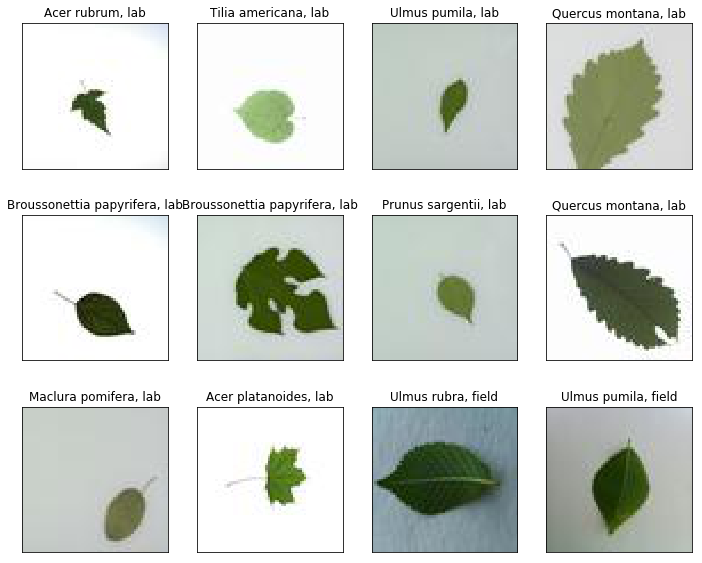

In [23]:
from code import data as d

d.plot_12images(images, labels, sources, figsize=(12,10))